<a href="https://colab.research.google.com/github/Liwenting7778/news_title_classification/blob/main/news_cluste.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

数据预处理：读取json文件，分词，去除标点符号后存入CSV文件（保留了"keywords", "title", "desc", "content"）

In [3]:
#解压
import zipfile
zf = zipfile.ZipFile('./data/new2016zh.zip')
print(zf.namelist())
zf.extractall()
zf.close()


#读取json文件
import json
with open('./data/news2016zh_train.json', 'r', encoding="utf-8") as f:
    lines = f.readlines()

#数据预处理，并存到csv文件
import csv
import os
import jieba
import re

stopwords = [i.strip() for i in open('./cn_stop_words.txt',"r", encoding="utf-8").readlines()]

#分词并且去除停用词
def pretty_cut(sentence):
    cut_list = jieba.lcut(''.join(re.findall('[\u4e00-\u9fa5]', sentence)), cut_all=True)
    for i in range(len(cut_list) - 1, -1, -1):
        if cut_list[i] in stopwords:
            del cut_list[i]
    return cut_list

with open(os.path.join("./data/news2016zh_train.csv"), "w", encoding="utf-8", newline='') as g:
    writer = csv.writer(g)
    writer.writerow(["keywords", "title", "desc", "content"])
    for line in lines:
        news = json.loads(line)
        keywords = news["keywords"].strip(" ")
        title = news["desc"].strip(" ")
        desc = news["desc"].strip(" ")
        content = news["content"].strip(" ")
        cut_keywords = " ".join(pretty_cut(keywords))
        cut_title = " ".join(pretty_cut(title))
        cut_desc = " ".join(pretty_cut(desc))
        cut_content = " ".join(pretty_cut(content))
        writer.writerow([cut_keywords, cut_title, cut_desc, cut_content])

导入必要的库

In [4]:
!pip install umap-learn -i https://mirrors.ustc.edu.cn/pypi/web/simple
!pip install hdbscan
!pip install sentence_transformers

Looking in indexes: https://mirrors.ustc.edu.cn/pypi/web/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 167 kB/s 
     |████████████████████████████████| 1.1 MB 386 kB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=cdc97618a689b61ce0ae2374d53fa0b5eb628d110bc94ff979ff900cb9e07cf5
  Stored in directory: /root/.cache/pip/wheels/ab/08/f8/98388f3fdbfc43aac05c98a3bce079cd212640c1adbeb2b617
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=c6e363315d7edb19f96e7cb7e9d114338fc1962ad38bfe2d1487d4a9f4da0f5b
  Stored in directory: /root/.cache/pip/wheels/9c/87/08/8032c8fdf442d43c7733dbb6129b48bc0c20c8046f26922dd8
Successfully built umap-learn pynndescent
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.2 MB 5.1 MB/s 
  Installing build dependencies ... do

In [5]:
import sys
import numpy as np
import pandas as pd
import jieba
import umap
import hdbscan
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import matplotlib.pyplot as plt

读取文本

In [6]:
#加载google的云端硬盘
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
data = pd.read_csv('/content/drive/MyDrive/news2016zh_valid.csv')

In [8]:
data.head()

,keywords,title,desc,content
0,借鉴 篇 受欢迎 欢迎 校训 没有 一个 字 讲学 讲学习 学习,知道 是因为 偶然 来到 世界 践行 一个 平凡 美丽 无私 梦想 而来 苦乐 逆 体验 来...,知道 是因为 偶然 来到 世界 践行 一个 平凡 美丽 无私 梦想 而来 苦乐 逆 体验 来...,知道 是因为 偶然 来到 世界 践行 一个 平凡 美丽 无私 梦想 而来 苦乐 逆 体验 来...
1,市民 淘宝 购物 一年 四度 忽悠 买货 容易 退货 难,张女士 女士 提供 豆 皮 虫 尸 证据 照片 受访 受访者 供 图 淘宝 购物 一年 忽悠...,张女士 女士 提供 豆 皮 虫 尸 证据 照片 受访 受访者 供 图 淘宝 购物 一年 忽悠...,张女士 女士 提供 豆 皮 虫 尸 证据 照片 受访 受访者 供 图 淘宝 购物 一年 忽悠...
2,统计 机械 电器 类 公司 市场 表现,名称 代码 收盘 收盘价 日 涨跌 周 涨跌 月 涨跌 季 涨跌 深 华新 中联 中联重科,名称 代码 收盘 收盘价 日 涨跌 周 涨跌 月 涨跌 季 涨跌 深 华新 中联 中联重科,名称 代码 收盘 收盘价 日 涨跌 周 涨跌 月 涨跌 季 涨跌 深 华新 中联 中联重科 ...
3,每日 技 四维 绕 杆 跑 练习,爱 高 体育 有趣 兼有 有料 校园 足球 足球资讯 资讯 平台 每日 分享 一招 足球 球...,爱 高 体育 有趣 兼有 有料 校园 足球 足球资讯 资讯 平台 每日 分享 一招 足球 球...,爱 高 体育 有趣 兼有 有料 校园 足球 足球资讯 资讯 平台 每日 分享 一招 足球 球...
4,漫 展 活动 风云 小分 小分队 分队,期待 期待已久 已久 万圣 动漫 音乐 音乐节 终于 风云 动漫 社 动物 动物园 小分 小...,期待 期待已久 已久 万圣 动漫 音乐 音乐节 终于 风云 动漫 社 动物 动物园 小分 小...,期待 期待已久 已久 万圣 动漫 音乐 音乐节 终于 风云 动漫 社 动物 动物园 小分 小...


In [9]:
#处理异常值
print("在 news 列中总共有 %d 个空值." % data['content'].isnull().sum())
data[data.isnull().values==True]#isnull返回一个布尔数组
data = data[pd.notnull(data['content'])]#保留非null的news

data['content']=data['content'].astype(str) #将数据类型都换成str

在 news 列中总共有 1010 个空值.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


创建句子嵌入

In [10]:
#创建语句嵌入
#model = SBert('paraphrase-multilingual-MiniLM-L12-v2')
%%time
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
embeddings = model.encode(data['content'].tolist(), show_progress_bar=True)

Downloading:   0%|          | 0.00/968 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/645 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/471M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/14.8M [00:00<?, ?B/s]

Batches:   0%|          | 0/2369 [00:00<?, ?it/s]

CPU times: user 2h 31min 34s, sys: 2min 33s, total: 2h 34min 8s
Wall time: 2h 32min 47s


In [11]:
embeddings.shape

(75787, 384)

句子嵌入降维处理

In [12]:

sys.setrecursionlimit(1000000)
umap_embeddings = umap.UMAP(n_neighbors=25,
               n_components=10,
               min_dist=0.00,
               metric='cosine',
               random_state=2020).fit_transform(embeddings)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


 利用HDBSCAN进行文档聚类

In [13]:

cluster = hdbscan.HDBSCAN(min_cluster_size=20,
                          metric='euclidean',
                          cluster_selection_method='eom', 
                          prediction_data=True).fit(umap_embeddings)

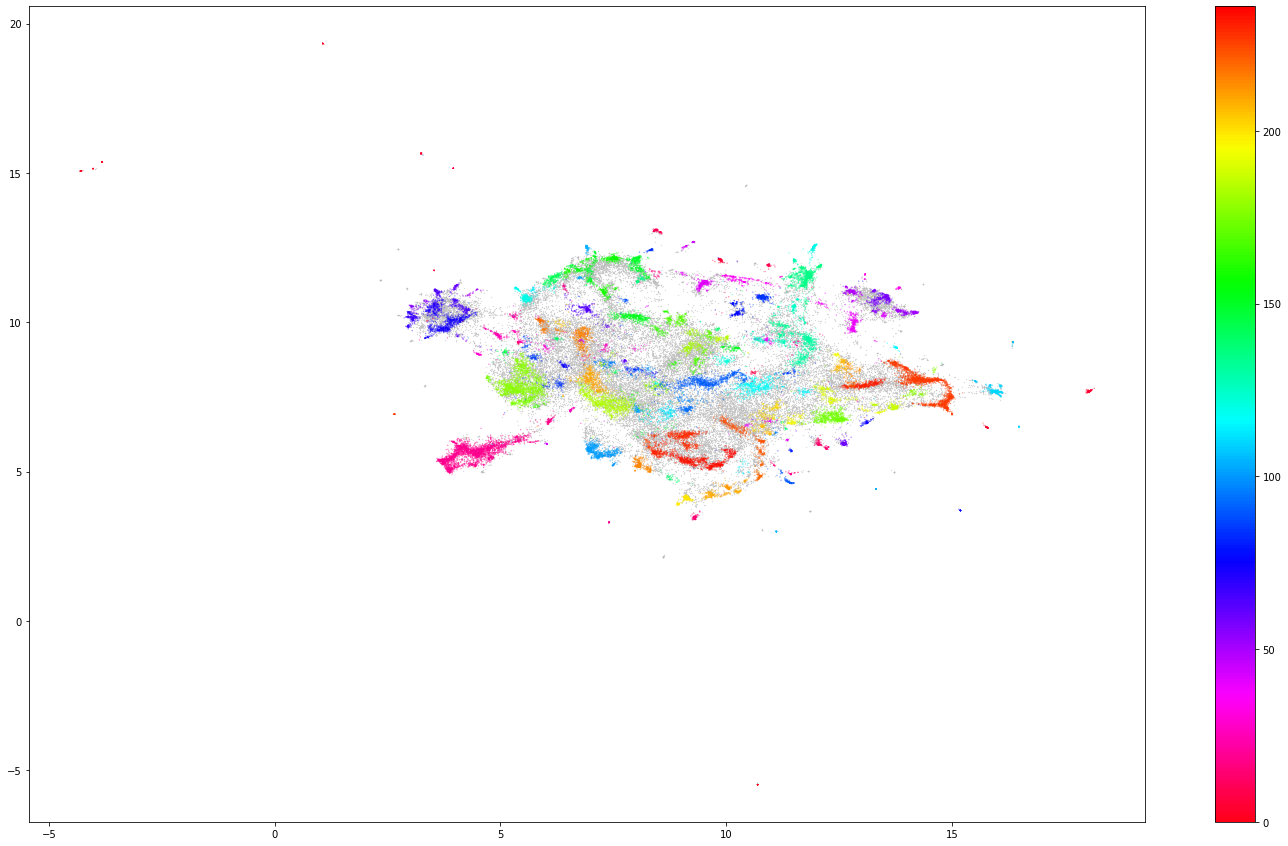

In [14]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, 
                      n_components=2, 
                      min_dist=0.0,
                      metric='cosine').fit_transform(embeddings)

result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(25, 15))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()
plt.savefig("result1.png", dpi = 300)

c-TF-IDF

In [15]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    my_stopwords =  [i.strip() for i in open('/content/drive/MyDrive/cn_stop_words.txt',encoding='utf-8').readlines()]
    """ Calculate a class-based TF-IDF where m is the number of total documents. """
    count = CountVectorizer(ngram_range=ngram_range, 
                            #tokenizer = lambda x : ' '.join(jieba.lcut(x)),
                            stop_words= my_stopwords).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

In [16]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

计算每个主题下的TOP主题词

In [17]:
docs_df = pd.DataFrame(data['content'].tolist(), columns=["Doc"]) 
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [18]:
len(docs_per_topic.Doc.tolist())

238

In [19]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m = len(data))

In [20]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic,Size
0,-1,41963
20,19,3065
227,226,1977
178,177,1550
185,184,998
136,135,965
92,91,877
175,174,780
102,101,665
74,73,663


In [21]:
#看看主题索引为18的主题下的主题词是哪些：
top_n_words[10]

[('咖啡', 0.19304002539539056),
 ('星巴克', 0.07794348959962737),
 ('巴克', 0.07292709732951254),
 ('速溶', 0.02575653233183367),
 ('蓝山', 0.02139686821157816),
 ('咖啡豆', 0.020062720133649684),
 ('咖啡机', 0.018767918971476207),
 ('门店', 0.018726917852014233),
 ('咖啡馆', 0.013932034335573181),
 ('烘焙', 0.012316028326546666),
 ('萃取', 0.011021511332351724),
 ('配送', 0.01042262108248891),
 ('咖啡粉', 0.010205455189886761),
 ('牙买加', 0.009722327456862103),
 ('咖啡因', 0.008970968279945191),
 ('麝香', 0.008874734264112127),
 ('喝咖啡', 0.008634963066523409),
 ('饮料', 0.008619270652474406),
 ('精品', 0.008444250444063483),
 ('加盟', 0.008397374520446331)]

In [22]:
# 删除索引为-1的聚类簇群
top_n_words[-1]
from pprint import pprint
for i in list(range(len(top_n_words) - 1)):
    print('Most 20 Important words in TOPIC {} :\n'.format(i))
    pprint(top_n_words[i])
    pprint('***'*20)

流式输出内容被截断，只能显示最后 5000 行内容。
 ('决赛', 0.006337987080367089),
 ('主场', 0.0061096021975251364),
 ('奥运', 0.005872096840929807),
 ('进球', 0.005762550838961714),
 ('教练', 0.005718848460600554),
 ('俱乐部', 0.00503090212908619),
 ('选手', 0.004727321123449301),
 ('巴西', 0.004545718328198044)]
'************************************************************'
Most 20 Important words in TOPIC 20 :

[('发球', 0.05191978635531896),
 ('投篮', 0.025823395388426484),
 ('数值', 0.02361915807305074),
 ('师父', 0.02123307055883649),
 ('练习', 0.018609791505362402),
 ('击球', 0.01652169599779376),
 ('球路', 0.016259963726044234),
 ('球员', 0.014042459445256734),
 ('运球', 0.013808818962944707),
 ('乒乓', 0.01361920852218763),
 ('动作', 0.013467031288922389),
 ('接发球', 0.013239422606261604),
 ('防守', 0.01304422854706789),
 ('跳步', 0.012821400417038917),
 ('乒乓球', 0.012208136535880128),
 ('接发', 0.012185049955853185),
 ('落点', 0.011763068005471418),
 ('高球', 0.01168242525113975),
 ('双打', 0.011547943059490386),
 ('选手', 0.011366869284885263)]
'******

主题归并

In [23]:
for i in tqdm(range(20)):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
  5%|▌         | 1/20 [01:08<21:50, 68.97s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
 10%|█         | 2/20 [02:19<20:54, 69.71s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
 15%|█▌        | 3/20

,Topic,Size
0,-1,42028
19,18,3065
207,206,1977
159,158,1570
166,165,998
122,121,965
82,81,877
156,155,780
92,91,665
65,64,663


查看归并之后的主题数

In [24]:
len(docs_per_topic.Doc.tolist())

218

查看归并后的所有主题及其对应的主题词列表：

In [25]:
from pprint import pprint
for i in list(range(len(top_n_words) - 1)):
    print('Most 20 Important words in TOPIC {} :\n'.format(i))
    pprint(top_n_words[i])
    pprint('***'*20)

Most 20 Important words in TOPIC 0 :

[('大侠', 0.9001381366122838),
 ('鼠标键', 0.5502328829713276),
 ('御用', 0.445024587375612),
 ('键盘', 0.4034635562188999),
 ('地址', 0.38353677484198967),
 ('坦克', 0.3756309484592343),
 ('鼠标', 0.3695312102410861),
 ('装备', 0.2127415605744503),
 ('键值', 0.10032798458397586),
 ('按键', 0.0843961745698152),
 ('世界', 0.07003588476920444),
 ('延时', 0.03648786909588618),
 ('返回', 0.03594489159112608),
 ('可定义', 0.02940115728908747),
 ('回空', 0.026665961074537756),
 ('转法', 0.02348772006859021),
 ('数组', 0.022527768951791816),
 ('标值', 0.022454059660477272),
 ('扫描', 0.021875871069330886),
 ('链接', 0.02104494763858503)]
'************************************************************'
Most 20 Important words in TOPIC 1 :

[('报告期', 0.02762776229073008),
 ('报告', 0.02273653944515373),
 ('基金', 0.022058171049317628),
 ('期末', 0.020400088362450844),
 ('证券', 0.018699325495822993),
 ('债券', 0.017724458551012245),
 ('净值', 0.017491720407287033),
 ('会计', 0.016844298551969387),
 ('本报', 0.0166637